# PUI Homework 9: Assignment 2 - Geopandas excercise

In [1]:
__author__ = 'Ruben Hambardzumyan, rh2684'

## 1. Template Setup

In [2]:
from __future__ import print_function, division
import numpy as np
import pandas as pd
import geopandas as gpd
import fiona
import shapely
import choroplethNYC
import urllib.request as url
import urllib, json
import pylab as pl
import os
from CensusAPI import myAPI
from io import StringIO
from fiona.crs import from_epsg

%pylab inline

# Checking the $PUIDATA environmental variable

if not os.environ.get('PUIDATA'):
    print('The $PUIDATA environmental variable does not exist!')

# Setting the significance level

alpha = 0.05

# Setting the random seed

np.random.seed(1452)

Populating the interactive namespace from numpy and matplotlib


## 2.1. Getting The Data

In [3]:
# Downloading the data through API

url.urlretrieve(u'https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile', 'puma.zip')

('puma.zip', <http.client.HTTPMessage at 0x7efff99f9748>)

In [4]:
!mkdir geo

In [5]:
# Unzipping the data to a directory to move to PUIdata

!unzip puma.zip -d geo

Archive:  puma.zip
  inflating: geo/geo_export_54c165c0-af00-453a-91c6-53716eb1aaf7.dbf  
  inflating: geo/geo_export_54c165c0-af00-453a-91c6-53716eb1aaf7.shp  
  inflating: geo/geo_export_54c165c0-af00-453a-91c6-53716eb1aaf7.shx  
  inflating: geo/geo_export_54c165c0-af00-453a-91c6-53716eb1aaf7.prj  


In [6]:
os.system('mv geo ' + os.getenv("PUIDATA"))

0

In [7]:
# Deleting the downloaded archive

!rm -f puma.zip

In [8]:
!ls $PUIDATA/geo

geo_export_54c165c0-af00-453a-91c6-53716eb1aaf7.dbf
geo_export_54c165c0-af00-453a-91c6-53716eb1aaf7.prj
geo_export_54c165c0-af00-453a-91c6-53716eb1aaf7.shp
geo_export_54c165c0-af00-453a-91c6-53716eb1aaf7.shx


In [9]:
# Creating the list of files in the folder

files = os.listdir(os.getenv("PUIDATA") + '/geo')

In [10]:
geoData = gpd.GeoDataFrame.from_file(os.getenv("PUIDATA") + "/geo/" + files[1])

In [11]:
geoData.head()

,puma,shape_leng,shape_area,geometry
0,3701,53227.144376,9.792852e+07,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,106050.008344,1.889860e+08,POLYGON ((-73.86477258283533 40.90201244187379...
2,3703,304875.033427,2.670770e+08,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,47970.900868,1.062129e+08,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,3705,68593.066759,1.224946e+08,POLYGON ((-73.87045508990893 40.86663286876232...


In [12]:
geoData.crs

{'init': 'epsg:4326'}

## 2.2. Plotting PUMA NYC Regions

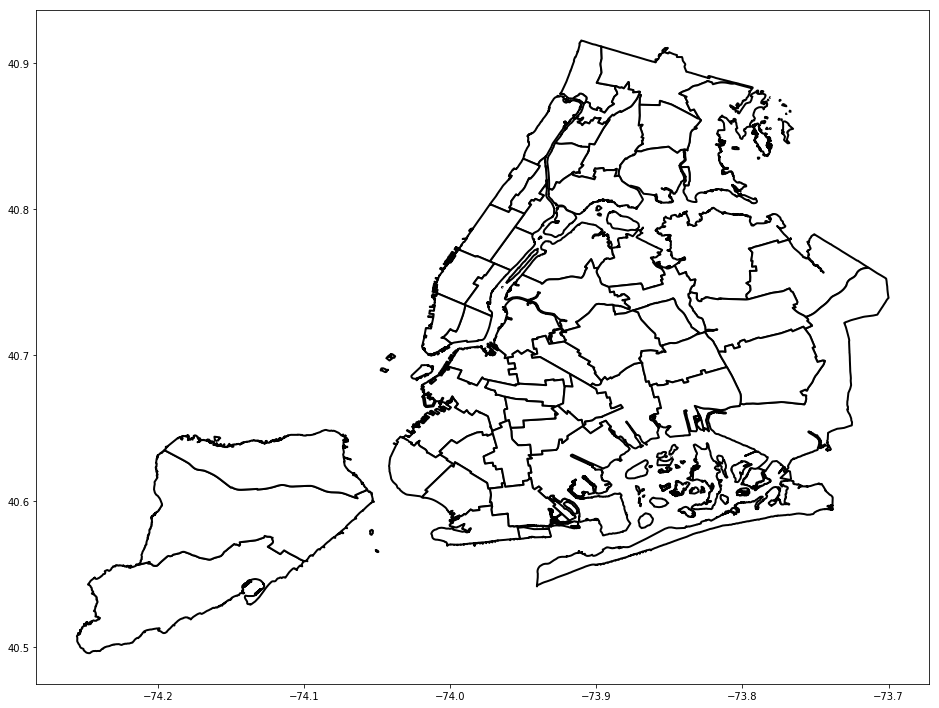

In [15]:
geoData.plot(figsize=(16, 14), color="white", edgecolor="black", lw=2)

### Figure 2.2.1
The figure shows the contours of PUMA regions of New York City. The plot is done by using GeoPandas native GeoDataFrame.plot function. X and Y axes show the geographical coordinates (latitude and longitude).

## 3.1 Getting The AmericanFactFinder Data

In [16]:
# Getting the AFF data from the CENSUS website

url = 'https://api.census.gov/data/2016/acs/acs1/variables.json'
req = urllib.request.Request(url)

read = urllib.request.urlopen(req).read()
aff = json.loads(read.decode('utf-8'))

In [17]:
# Turning the variables from .Json into Numpy array

affkeys = np.array(list(aff['variables'].keys()))

In [18]:
#extracting variables of B28002 that contain "broadband"
[(k, aff['variables'][k]['label'])  for k in affkeys if k.startswith ("B28002") and 
 'Broadband' in aff['variables'][k]['label']]

[('B28002_007M',
  'Margin of Error!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL'),
 ('B28002_007MA',
  'Annotation of Margin of Error!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL'),
 ('B28002_008EA',
  'Annotation of Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription'),
 ('B28002_004MA',
  'Annotation of Margin of Error!!Total!!With an Internet subscription!!Broadband of any type'),
 ('B28002_007E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL'),
 ('B28002_004E',
  'Estimate!!Total!!With an Internet subscription!!Broadband of any type'),
 ('B28002_008E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscriptio

In [19]:
#keyword for the number of households

keyNhouseholds = 'B28002_001E'
aff['variables'][keyNhouseholds]

{'attributes': 'B28002_001M,B28002_001EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total',
 'limit': 0,
 'predicateType': 'int',
 'validValues': []}

In [20]:
#keyword for the number of households with broadband access

keyNBB = 'B28002_004E'
aff['variables'][keyNBB]

{'attributes': 'B28002_004M,B28002_004EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total!!With an Internet subscription!!Broadband of any type',
 'limit': 0,
 'predicateType': 'int',
 'validValues': []}

In [21]:
# Getting the broadband access number of households

url2 = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNBB +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
req2 = urllib.request.Request(url2)

read2 = urllib.request.urlopen(req2).read()

In [22]:
pumaBB = pd.read_csv(StringIO(read2.decode('utf-8').replace('[','').replace(']','')))

pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,Unnamed: 4
0,32607,"St. Lawrence County PUMA, New York",36,100,NaN
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,41210,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [23]:
#getting the first row of the table: the total number of households
url3 = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNhouseholds +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
req3 = urllib.request.Request(url3)

read3 = urllib.request.urlopen(req3).read()

In [24]:
pumaPP = pd.read_csv(StringIO(read3.decode('utf-8').replace('[','').replace(']','')))

pumaPP.head()

,B28002_001E,NAME,state,public use microdata area,Unnamed: 4
0,40479,"St. Lawrence County PUMA, New York",36,100,NaN
1,67092,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,51614,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,44300,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,61146,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


## 3.2. Percentage of Households with Broadband Access

In [25]:
pumaBB['B28002_001E'] = pumaPP['B28002_001E']

In [26]:
pumaBB.drop('Unnamed: 4', axis=1, inplace=True)

In [27]:
# adding the percentage column

pumaBB['pcBB'] = pumaBB['B28002_004E'] / pumaBB['B28002_001E'] * 100

In [28]:
pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,B28002_001E,pcBB
0,32607,"St. Lawrence County PUMA, New York",36,100,40479,80.552879
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,67092,75.733321
2,41210,"Warren & Washington Counties PUMA, New York",36,300,51614,79.842678
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,44300,81.433409
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,61146,78.150656


## 3.3. Percentage Comparison With AFF Published Data

In [29]:
# Getting the comparison table, after uploading it to PUIdata

!unzip $PUIDATA/aff_download.zip -d $PUIDATA

Archive:  /home/cusp/rh2684/PUIdata/aff_download.zip
  inflating: /home/cusp/rh2684/PUIdata/ACS_16_1YR_GCT2801.ST50_with_ann.csv  
  inflating: /home/cusp/rh2684/PUIdata/ACS_16_1YR_GCT2801.ST50_metadata.csv  
  inflating: /home/cusp/rh2684/PUIdata/ACS_16_1YR_GCT2801.ST50.txt  
  inflating: /home/cusp/rh2684/PUIdata/aff_download_readme_ann.txt  


In [30]:
bbpc = pd.read_csv(os.getenv("PUIDATA") + "/ACS_16_1YR_GCT2801.ST50_with_ann.csv",
            usecols=["GCT_STUB.target-geo-id2","HC01","HC02"])

bbpc.head()

,GCT_STUB.target-geo-id2,HC01,HC02
0,Target Geo Id2,Percent,Margin of Error
1,01,74.7,0.5
2,0100100,70.9,2.5
3,0100200,80.5,2.7
4,0100301,87.0,2.8


In [37]:
bbpc["GCT_STUB.target-geo-id2"] = pd.to_numeric(bbpc["GCT_STUB.target-geo-id2"], errors='coerce')

In [38]:
bbpc["GCT_STUB.target-geo-id2"] = bbpc["GCT_STUB.target-geo-id2"] - 3600000

In [39]:
diff_ = pumaBB.merge(bbpc, right_on="GCT_STUB.target-geo-id2", 
                     left_on="public use microdata area")[["pcBB", "HC01"]]

diff_["diff"] = np.abs(diff_["pcBB"] - diff_["HC01"].astype(float))

diff_.describe()

,pcBB,diff
count,145.000000,145.000000
mean,81.845478,0.026217
std,7.063369,0.014480
min,54.932945,0.000178
25%,77.770257,0.012252
50%,82.826141,0.027230
75%,87.305077,0.039090
max,93.404143,0.049872


## 4.1. Merge With The PUMA Geodataframe and plot a choropleth of the percentage of households with broadband access

In [40]:
puma = pumaBB.iloc[90:144]

In [41]:
puma = puma.rename(index=str, columns={"public use microdata area": "puma"});

In [42]:
geoData.puma = pd.to_numeric(geoData.puma, errors='coerce')

In [43]:
geoData = geoData.merge(puma, on='puma')

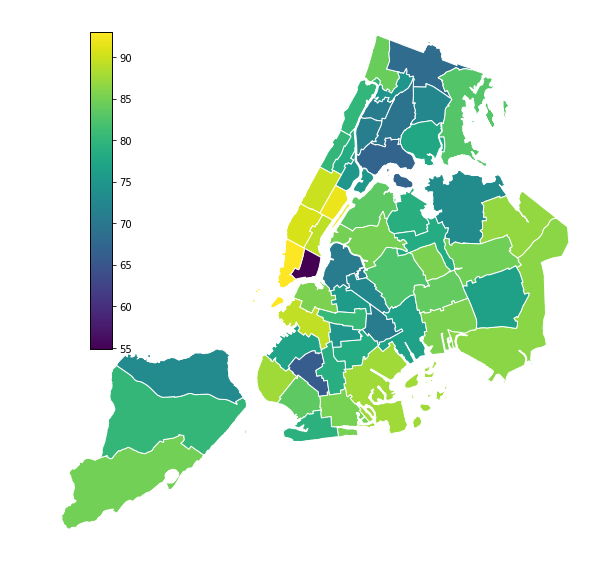

In [44]:
ax = choroplethNYC.choroplethNYC(geoData, column="pcBB", color="white",cmap="viridis", edgecolor="white", lw=1)

### Figure 4.1.1
The figure above shows the PUMA regions of NYC according to the percentage of households with access to broadband connection. It is interesting, that East Village, being close to Financial District with the highest percentage of broadband connection, shows the lowest value of only 55% of households having access to broadband connection.

## 5. LinkNYC

In [45]:
linkNYC = pd.read_csv('https://github.com/fedhere/PUI2017_fb55/raw/master/HW9_fb55/linkNYClocations.csv')

In [46]:
linkNYC.head()

,Unnamed: 0,link_site,longitude,date_link_,latitude
0,0,bk-01-138951,-73.942489,2017-07-01,40.701668
1,1,bk-01-109091,-73.942169,2017-07-01,40.701542
2,2,bk-01-143982,-73.942239,2017-07-01,40.701930
3,3,bk-01-109262,-73.942918,2017-04-28,40.705060
4,4,bk-01-125268,-73.953439,2017-03-31,40.728133


In [47]:
linkNYC.shape

(1414, 5)

In [48]:
linkNYC['lonlat'] = list(zip(linkNYC.longitude, linkNYC.latitude))

In [49]:
linkNYC['geometry'] = linkNYC[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
linkNYC.head()

,Unnamed: 0,link_site,longitude,date_link_,latitude,lonlat,geometry
0,0,bk-01-138951,-73.942489,2017-07-01,40.701668,"(-73.94248859, 40.70166753)",POINT (-73.94248859 40.70166753)
1,1,bk-01-109091,-73.942169,2017-07-01,40.701542,"(-73.9421692831, 40.7015421938)",POINT (-73.9421692831 40.7015421938)
2,2,bk-01-143982,-73.942239,2017-07-01,40.701930,"(-73.9422392385, 40.7019303439)",POINT (-73.94223923850001 40.7019303439)
3,3,bk-01-109262,-73.942918,2017-04-28,40.705060,"(-73.94291758, 40.70506042)",POINT (-73.94291758 40.70506042)
4,4,bk-01-125268,-73.953439,2017-03-31,40.728133,"(-73.953439, 40.728133)",POINT (-73.953439 40.728133)


In [50]:
linkNYC = gpd.GeoDataFrame(linkNYC)
linkNYC.crs = {'init': 'epsg:4326'}

In [51]:
link = pd.DataFrame(columns=['geometry'])
link.geometry = linkNYC.geometry

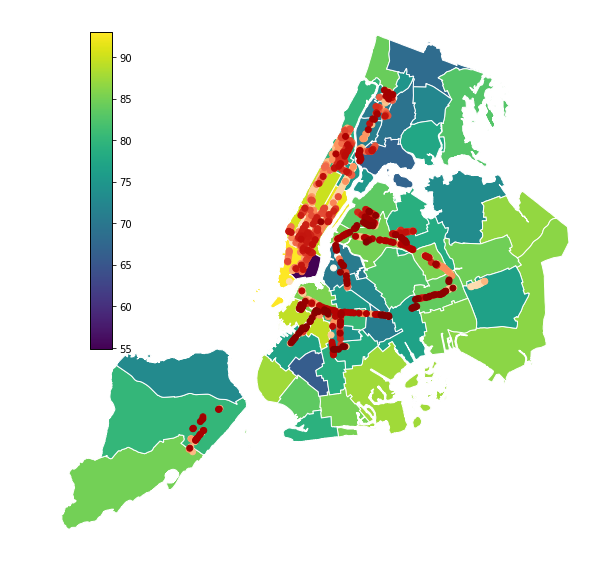

In [52]:
Obj, fig, axes = choroplethNYC.choroplethNYC(geoData, "pcBB", color="white", cmap="viridis", edgecolor="white", lw=1)
linkNYC.plot(ax=fig, cmap="OrRd")

### Figure 5.1

The figure above shows the PUMA regions of NYC according to the percentage of households with access to broadband connection. On the map, the dots correspond to the locations of LinkNYC points. Color mapping of linkNYC locations differ according to date of installment.

## 6.1. with the AFF API from ACS get the total population by puma and merge it into your GeoDF

In [53]:
pumaPop = pd.DataFrame(columns=['B00001_001E', 'NAME', 'state', 'puma'])

pumaPop.NAME = pumaBB.NAME
pumaPop.state = pumaBB.state
pumaPop.puma = pumaBB['public use microdata area']

In [54]:
keyPop = 'B00001_001E'
aff['variables'][keyPop]

{'attributes': 'B00001_001EA',
 'concept': 'UNWEIGHTED SAMPLE COUNT OF THE POPULATION',
 'group': 'B00001',
 'label': 'Estimate!!Total',
 'limit': 0,
 'predicateType': 'int',
 'validValues': []}

In [55]:
urlPop = "https://api.census.gov/data/2016/acs/acs1?get=" + keyPop +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
reqPop = urllib.request.Request(urlPop)

readPop = urllib.request.urlopen(reqPop).read()

In [56]:
pop = pd.read_csv(StringIO(readPop.decode('utf-8').replace('[','').replace(']','')))

In [57]:
pumaPop['B00001_001E'] = pop['B00001_001E']

In [58]:
pumaPop.head()

,B00001_001E,NAME,state,puma
0,3075,"St. Lawrence County PUMA, New York",36,100
1,4356,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200
2,2736,"Warren & Washington Counties PUMA, New York",36,300
3,2722,Herkimer (North & Central) & Oneida (Outer) Co...,36,401
4,2874,Oneida County (Central)--Greater Utica & Rome ...,36,402


## 6.2. find the number of station per 100 people per PUMA

In [59]:
geoData.geometry = geoData.geometry.to_crs(epsg=2263)

In [60]:
linkNYC.geometry = linkNYC.geometry.to_crs(epsg=2263)

In [61]:
linkpp = gpd.sjoin(geoData,linkNYC).groupby('puma').count()[['date_link_']]

In [62]:
linkpp.head()

,date_link_
puma,
3701,1
3705,1
3706,20
3707,29
3708,19


In [63]:
linkpp.reset_index(inplace=True)

In [64]:
pumashplc = geoData.merge(linkpp,on='puma',how='outer').fillna(0)

In [65]:
pumashplc['linkNYCp100p'] = pumashplc['date_link_']/pumaPop['B00001_001E']*100

In [66]:
pumashplc.head()

,puma,shape_leng,shape_area,geometry,B28002_004E,NAME,state,B28002_001E,pcBB,date_link_,linkNYCp100p
0,3701,53227.144376,9.792852e+07,"POLYGON ((1012885.033996583 268830.4841918442,...",35529,"NYC-Bronx Community District 8--Riverdale, Fie...",36,42158,84.275820,1.0,0.032520
1,3702,106050.008344,1.889860e+08,"POLYGON ((1021632.335632326 267934.4393920284,...",34030,"NYC-Bronx Community District 12--Wakefield, Wi...",36,49817,68.310015,0.0,0.000000
2,3703,304875.033427,2.670770e+08,(POLYGON ((1042822.450195312 243439.8142089319...,36716,"NYC-Bronx Community District 10--Co-op City, P...",36,44329,82.826141,0.0,0.000000
3,3704,47970.900868,1.062129e+08,"POLYGON ((1026308.769592285 256767.6972045382,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,36,44476,72.553737,0.0,0.000000
4,3705,68593.066759,1.224946e+08,"POLYGON ((1020080.524597168 255041.8771972096,...",40757,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,58706,69.425612,1.0,0.034795


## 6.3. Plot the linkNYC locations on top of a choropleth of number of stations per 100 people  in 10 equal intervals

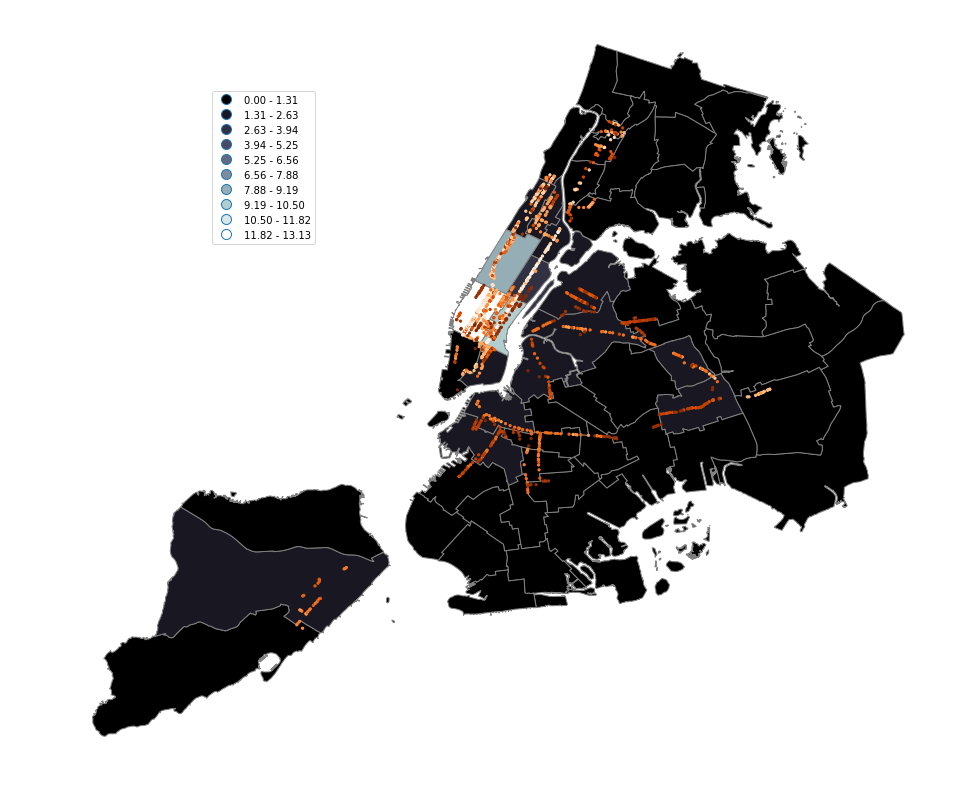

In [67]:
fig = plt.figure(figsize=(16,14))
ax = fig.add_subplot(111)

ax.axis('off')

pumashplc.plot(column='linkNYCp100p', edgecolor='gray', ax=ax, legend=True, cmap='bone', scheme='equal_interval', k=10)

linkNYC.plot(column='date_link_',ax=ax,markersize=5,cmap='Oranges')
leg = ax.get_legend()
leg.set_bbox_to_anchor((0., 0.7, 0.3, 0.2))

### Figure 6.3.1

The figure above shows the map of NYC puma regions and locations of linkNYC routers per 100 people.